# CAP 5610 - Introduction to Machine Learning <br>Florida International University - Summer 2019
## Final Project - Exploring Chat-Bot Learning With Synthetic MNIST GUESS NUMBER Dataset
### Group 7 - Khrystsina Navumenka

In this project a synthetic MNIST GuessNumber dataset is explored. The dataset consists of grid images (3 X 3) where each cell has a pre-defined background color, digit, digit style, and digit color. A randomly selected cell in each grid image constitutes "target" for the given image. In order to predict the target, a set of questions and answers for each grid image is used to identify the features of the target cell. This approach is typically used to train chat bots so that they could provide the best response based on the customers' answers.

In [2]:
# Load libraries
from __future__ import print_function
import numpy as np
from num2words import num2words
import operator as op
import scipy.misc
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
import tarfile
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, CuDNNLSTM
from pandas.io.json import json_normalize
import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from six.moves.urllib.request import urlretrieve

The MNIST Guess Number dataset has been generated using the generate_data.py algorithm and the well-known MNIST dataset as an input. The resulting dataset consists of grid images and nested JSON files that include feature values, questions, and answers for each image. Therefore, each data sample consists of set of features for each cell in Grid Image, set of associated questions and answers about the Grid Image, and the Target cell in the given Grid Image.

### Now, lets explore the raw data samples:

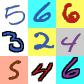

In [3]:
# We can display images using Image(filename="")
Image(filename="data/mnist_guess_number/imgs/test/00000.jpg")

In [4]:
# Load the nested JSON data for test, train, and validation sets into the workspace:
valid = []
with open('data/mnist_guess_number/valid.json') as val:
    for line in val:
        valid.append(json.loads(line))

train = []
with open('data/mnist_guess_number/train.json') as trn:
    for line in trn:
        train.append(json.loads(line))

test = []
with open('data/mnist_guess_number/test.json') as tst:
    for line in tst:
        test.append(json.loads(line))   
        
# Display JSON line associated with first data sample in test set
test[0]

{'img': 0,
 'qa': [{'question': 'Is it 6 in the image ?', 'answer': 'no'},
  {'question': 'Is it in a silver background ?', 'answer': 'no'},
  {'question': 'Is it a stroke style digit ?', 'answer': 'no'},
  {'question': 'Is it in a white background ?', 'answer': 'yes'}],
 'target': [0, 0],
 'gridImg': [[{'number': 5,
    'color': 'blue',
    'bgcolor': 'white',
    'style': 'flat'},
   {'number': 6, 'color': 'blue', 'bgcolor': 'cyan', 'style': 'flat'},
   {'number': 6, 'color': 'red', 'bgcolor': 'yellow', 'style': 'flat'}],
  [{'number': 3, 'color': 'blue', 'bgcolor': 'white', 'style': 'stroke'},
   {'number': 2, 'color': 'blue', 'bgcolor': 'yellow', 'style': 'flat'},
   {'number': 4, 'color': 'violet', 'bgcolor': 'silver', 'style': 'flat'}],
  [{'number': 5, 'color': 'brown', 'bgcolor': 'salmon', 'style': 'flat'},
   {'number': 4, 'color': 'red', 'bgcolor': 'white', 'style': 'stroke'},
   {'number': 6, 'color': 'violet', 'bgcolor': 'cyan', 'style': 'stroke'}]]}

The above data format is very difficult for processing so the next step includes parsing the JSON files into manageable and meaningful features. The general approach here is the natural language learning approach: almost each word/number serves as a separate feature. The recurrent Neural Networks (RNN) are meant to learn not only based on feature values but also on the order in which these values are present. We will preserve the order of feature values while generating the training data.

Below are some examples of how the data can be parsed:

In [5]:
# Extract all properties associated with one grid image - (probably too much information for 
# just one feature)
Img_prop = test[0]['gridImg']
Img_prop

[[{'number': 5, 'color': 'blue', 'bgcolor': 'white', 'style': 'flat'},
  {'number': 6, 'color': 'blue', 'bgcolor': 'cyan', 'style': 'flat'},
  {'number': 6, 'color': 'red', 'bgcolor': 'yellow', 'style': 'flat'}],
 [{'number': 3, 'color': 'blue', 'bgcolor': 'white', 'style': 'stroke'},
  {'number': 2, 'color': 'blue', 'bgcolor': 'yellow', 'style': 'flat'},
  {'number': 4, 'color': 'violet', 'bgcolor': 'silver', 'style': 'flat'}],
 [{'number': 5, 'color': 'brown', 'bgcolor': 'salmon', 'style': 'flat'},
  {'number': 4, 'color': 'red', 'bgcolor': 'white', 'style': 'stroke'},
  {'number': 6, 'color': 'violet', 'bgcolor': 'cyan', 'style': 'stroke'}]]

In [6]:
# Extract all question and answers associated with one grid image. Could be sufficient for one feature.
# However, separsing them into multiple features while keeping their order the same should give
# pattern-related information during the learning process. 

Img_qa = test[0]['qa']
Img_qa

[{'question': 'Is it 6 in the image ?', 'answer': 'no'},
 {'question': 'Is it in a silver background ?', 'answer': 'no'},
 {'question': 'Is it a stroke style digit ?', 'answer': 'no'},
 {'question': 'Is it in a white background ?', 'answer': 'yes'}]

In [7]:
# Extract target value:
Img_tar = test[0]['target']
Img_tar

[0, 0]

In [8]:
# Extract color of a digit in selected grid image cell
# At this level of parsing the value becomes meaningless, patterns are lost
I1 = test[0]['gridImg'][0][0]['color']
I1

'blue'

In [9]:
# Extract an individual question associated with data sample.
# Again, we need a set of them in a particular order to form a pattern:
Img_qaq = test[0]['qa'][0]['question']
Img_qaq

'Is it 6 in the image ?'

In [10]:
# Write a few simple functions to extract the features for training:
#--------------------------------------------------------------------
# Expecting a total of 52 features to be extracted
def extract_qa(IN):  #Extracting 16 questions and answers in correct order
    Q1 = []
    A1 = []
    Q2 = []
    A2 = []
    Q3 = []
    A3 = []
    Q4 = []
    A4 = []
    Q5 = []
    A5 = []
    Q6 = []
    A6 = []
    Q7 = []
    A7 = []
    Q8 = []
    A8 = []
    for line in range(len(IN)):
        Q = []
        A = []
        for n in range(len(IN[line]['qa'])):
            Q.append(IN[line]['qa'][n]['question'])
            A.append(IN[line]['qa'][n]['answer'])
        if len(IN[line]['qa']) < 8:          # Since data samples have different amounts of Q&As (2 to 8), add padding:
            nones = 8 - len(IN[line]['qa'])
            for m in range(nones):
                Q.append('ZERO') # We want to mae sure this value starts with lower alpha than Yes and No 
                                 # To ensure the uniform encoding across features
                A.append('ZERO')
        Q1.append(str(Q[0]))
        A1.append(str(A[0]))
        Q2.append(str(Q[1]))
        A2.append(str(A[1]))
        Q3.append(str(Q[2]))
        A3.append(str(A[2]))
        Q4.append(str(Q[3]))
        A4.append(str(A[3]))
        Q5.append(str(Q[4]))
        A5.append(str(A[4]))
        Q6.append(str(Q[5]))
        A6.append(str(A[5]))
        Q7.append(str(Q[6]))
        A7.append(str(A[6]))
        Q8.append(str(Q[7]))
        A8.append(str(A[7]))
    return Q1, A1, Q2, A2, Q3, A3, Q4, A4, Q5, A5, Q6, A6, Q7, A7, Q8, A8

Qu1, An1, Qu2, An2, Qu3, An3, Qu4, An4, Qu5, An5, Qu6, An6, Qu7, An7, Qu8, An8 = extract_qa(train + test + valid) 
#+ extract_qa(test) + extract_qa(valid)

#Print some examples to verify the features extracted as desired
print(An3[16])
print(Qu7[16])

no
ZERO


In [11]:
#Next, we extract number, color, bgcolot, and style (each of them is 9 features)

def extract_num(IN):  #Extracting numbers in order
    I1 = []
    I2 = []
    I3 = []
    I4 = []
    I5 = []
    I6 = []
    I7 = []
    I8 = []
    I9 = []
    for i in range(len(IN)):
        I1.append(str(IN[i]['gridImg'][0][0]['number']))
        I2.append(str(IN[i]['gridImg'][0][1]['number']))
        I3.append(str(IN[i]['gridImg'][0][2]['number']))
        I4.append(str(IN[i]['gridImg'][1][0]['number']))
        I5.append(str(IN[i]['gridImg'][1][1]['number']))
        I6.append(str(IN[i]['gridImg'][1][2]['number']))
        I7.append(str(IN[i]['gridImg'][2][0]['number']))
        I8.append(str(IN[i]['gridImg'][2][1]['number']))
        I9.append(str(IN[i]['gridImg'][2][2]['number']))
    return I1, I2, I3, I4, I5, I6, I7, I8, I9

def extract_col(IN):  #Extracting colors in order
    I1 = []
    I2 = []
    I3 = []
    I4 = []
    I5 = []
    I6 = []
    I7 = []
    I8 = []
    I9 = []
    for i in range(len(IN)):
        I1.append(str(IN[i]['gridImg'][0][0]['color']))
        I2.append(str(IN[i]['gridImg'][0][1]['color']))
        I3.append(str(IN[i]['gridImg'][0][2]['color']))
        I4.append(str(IN[i]['gridImg'][1][0]['color']))
        I5.append(str(IN[i]['gridImg'][1][1]['color']))
        I6.append(str(IN[i]['gridImg'][1][2]['color']))
        I7.append(str(IN[i]['gridImg'][2][0]['color']))
        I8.append(str(IN[i]['gridImg'][2][1]['color']))
        I9.append(str(IN[i]['gridImg'][2][2]['color']))
    return I1, I2, I3, I4, I5, I6, I7, I8, I9

def extract_bgc(IN):  #Extracting bgcolors in order
    I1 = []
    I2 = []
    I3 = []
    I4 = []
    I5 = []
    I6 = []
    I7 = []
    I8 = []
    I9 = []
    for i in range(len(IN)):
        I1.append(str(IN[i]['gridImg'][0][0]['bgcolor']))
        I2.append(str(IN[i]['gridImg'][0][1]['bgcolor']))
        I3.append(str(IN[i]['gridImg'][0][2]['bgcolor']))
        I4.append(str(IN[i]['gridImg'][1][0]['bgcolor']))
        I5.append(str(IN[i]['gridImg'][1][1]['bgcolor']))
        I6.append(str(IN[i]['gridImg'][1][2]['bgcolor']))
        I7.append(str(IN[i]['gridImg'][2][0]['bgcolor']))
        I8.append(str(IN[i]['gridImg'][2][1]['bgcolor']))
        I9.append(str(IN[i]['gridImg'][2][2]['bgcolor']))
    return I1, I2, I3, I4, I5, I6, I7, I8, I9

def extract_stl(IN):  #Extracting styles in order
    I1 = []
    I2 = []
    I3 = []
    I4 = []
    I5 = []
    I6 = []
    I7 = []
    I8 = []
    I9 = []
    for i in range(len(IN)):
        I1.append(str(IN[i]['gridImg'][0][0]['style']))
        I2.append(str(IN[i]['gridImg'][0][1]['style']))
        I3.append(str(IN[i]['gridImg'][0][2]['style']))
        I4.append(str(IN[i]['gridImg'][1][0]['style']))
        I5.append(str(IN[i]['gridImg'][1][1]['style']))
        I6.append(str(IN[i]['gridImg'][1][2]['style']))
        I7.append(str(IN[i]['gridImg'][2][0]['style']))
        I8.append(str(IN[i]['gridImg'][2][1]['style']))
        I9.append(str(IN[i]['gridImg'][2][2]['style']))
    return I1, I2, I3, I4, I5, I6, I7, I8, I9

# Fnally extract targets
def extract_tar(IN): #Extracting targets
    T = []
    for i in range(len(IN)):
        T.append(str(IN[i]['target']))
    return T

N1, N2, N3, N4, N5, N6, N7, N8, N9 = extract_num(train + test + valid)
C1, C2, C3, C4, C5, C6, C7, C8, C9 = extract_col(train + test + valid)
B1, B2, B3, B4, B5, B6, B7, B8, B9 = extract_bgc(train + test + valid)
S1, S2, S3, S4, S5, S6, S7, S8, S9 = extract_stl(train + test + valid)

print(S9[45000])

Tar = extract_tar(train + test + valid)

print(Tar[49000])

stroke
[0, 1]


Now that we have combined the three data files (for uniformity of further pre-processing) and 
extracted all the features, we need to create the new better manageable dataset and encode it
so it can be fed into a neural network.

In [12]:
#Create a dataframe containing the featureS and targets:
Dset_df = pd.DataFrame(list(zip(Qu1, An1, Qu2, An2, Qu3, An3, Qu4, An4, Qu5, An5, Qu6, An6, Qu7, An7, Qu8, An8,
                                N1, C1, B1, S1, N2, C2, B2, S2, N3, C3, B3, S3,
                                N4, C4, B4, S4, N5, C5, B5, S5, N6, C6, B6, S6,
                                N7, C7, B7, S7, N8, C8, B8, S8, N9, C9, B9, S9, Tar)), 
                            columns =['Q1', 'A1', 'Q2', 'A2', 'Q3', 'A3', 'Q4', 'A4', 'Q5', 'A5', 'Q6', 'A6', 'Q7', 'A7', 'Q8', 'A8',
                                      'N1', 'C1', 'B1', 'S1', 'N2', 'C2', 'B2', 'S2', 'N3', 'C3', 'B3', 'S3',
                                      'N4', 'C4', 'B4', 'S4', 'N5', 'C5', 'B5', 'S5', 'N6', 'C6', 'B6', 'S6',
                                      'N7', 'C7', 'B7', 'S7', 'N8', 'C8', 'B8', 'S8', 'N9', 'C9', 'B9', 'S9', 'Target'])
                                      
Dset_df.dtypes

Q1        object
A1        object
Q2        object
A2        object
Q3        object
A3        object
Q4        object
A4        object
Q5        object
A5        object
Q6        object
A6        object
Q7        object
A7        object
Q8        object
A8        object
N1        object
C1        object
B1        object
S1        object
N2        object
C2        object
B2        object
S2        object
N3        object
C3        object
B3        object
S3        object
N4        object
C4        object
B4        object
S4        object
N5        object
C5        object
B5        object
S5        object
N6        object
C6        object
B6        object
S6        object
N7        object
C7        object
B7        object
S7        object
N8        object
C8        object
B8        object
S8        object
N9        object
C9        object
B9        object
S9        object
Target    object
dtype: object

Object/str data type is not that suitable for feeding into the neural networks. 
Therefore, we need to make further manipulations and encode the features into a set of values
processable by NNs. But first, we have to determine the vocabulary sizes i.e. how many unique 
values each feature takes since these features are to be treated as categorical data:

In [13]:
Dset_df.apply(pd.Series.nunique)

Q1        22
A1         2
Q2        23
A2         3
Q3        23
A3         3
Q4        23
A4         3
Q5        23
A5         3
Q6        23
A6         3
Q7        23
A7         3
Q8        23
A8         3
N1        10
C1         5
B1         5
S1         2
N2        10
C2         5
B2         5
S2         2
N3        10
C3         5
B3         5
S3         2
N4        10
C4         5
B4         5
S4         2
N5        10
C5         5
B5         5
S5         2
N6        10
C6         5
B6         5
S6         2
N7        10
C7         5
B7         5
S7         2
N8        10
C8         5
B8         5
S8         2
N9        10
C9         5
B9         5
S9         2
Target     9
dtype: int64

From the output above we can see that some of the input features have 2 to 23 unique values. This is 
pretty good alphabet for encoding and further training.

Finally, lets take a look at our dataset:
-----------------------------------------

In [14]:
Dset_df.head(5)

Q1  A1                            Q2   A2  \
0        Is it 2 in the image ?  no  Is it in a cyan background ?   no   
1  Is it in a cyan background ?  no     Is it a digit in violet ?  yes   
2        Is it a digit in red ?  no      Is it a digit in brown ?  yes   
3        Is it 0 in the image ?  no      Is it a digit in green ?  yes   
4        Is it 2 in the image ?  no    Is it a flat style digit ?   no   

                             Q3    A3                              Q4    A4  \
0        Is it 9 in the image ?   yes   Is it in a white background ?   yes   
1        Is it 8 in the image ?    no  Is it in a yellow background ?   yes   
2                          ZERO  ZERO                            ZERO  ZERO   
3        Is it 7 in the image ?    no    Is it a stroke style digit ?   yes   
4  Is it a stroke style digit ?   yes          Is it a digit in red ?   yes   

                             Q5    A5  ...      S7 N8      C8      B8      S8  \
0  Is it a stroke style digit ?   yes  ...  stroke  2   brown   white  stroke   
1        Is it 1 in the image ?    no  ...    flat  3     red   white  stroke   
2                          ZERO  ZERO  ...    flat  8  violet  salmon  stroke   
3        Is it 4 in the image ?   yes  ...    flat  5     red   white  stroke   
4        Is it 9 in the image ?   yes  ...    flat  3    blue  silver    flat   

  N9      C9      B9      S9  Target  
0  0     red  yellow    flat  [0, 2]  
1  8  violet   white  stroke  [1, 0]  
2  7     red  yellow  stroke  [0, 0]  
3  4   green   white  stroke  [2, 2]  
4  2   green    cyan    flat  [1, 2]  

[5 rows x 53 columns]

At this point, we will encode our string values i. e. give each unique feature value a unique numeric identifier

In [15]:
# Try encoding using sklearn tools:
Enc = Dset_df.select_dtypes(include = [object])
le = preprocessing.LabelEncoder()
LEncoded = Enc.apply(le.fit_transform)
print('This is what the ENCODED dataset now looks like:')
print('------------------------------------------------')
LEncoded.head()

This is what the ENCODED dataset now looks like:
------------------------------------------------


Q1  A1  Q2  A2  Q3  A3  Q4  A4  Q5  A5  ...  S7  N8  C8  B8  S8  N9  C9  \
0   2   0  17   1   9   2  20   2  16   2  ...   1   2   1   3   1   0   3   
1  17   0  14   2   8   1  21   2   1   1  ...   0   3   3   3   1   8   4   
2  13   0  11   2  22   0  22   0  22   0  ...   0   8   4   1   1   7   3   
3   0   0  12   2   7   1  16   2   4   2  ...   0   5   3   3   1   4   2   
4   2   0  15   1  16   2  13   2   9   2  ...   0   3   0   2   0   2   2   

   B9  S9  Target  
0   4   0       2  
1   3   1       3  
2   4   1       0  
3   3   1       8  
4   0   0       5  

[5 rows x 53 columns]

In [16]:
#Need to find out the sizes of encoded features and targets by encoding the entire dataset and features only:

onehotencoderX = preprocessing.OneHotEncoder(categories = 'auto')
Test = LEncoded.iloc[:, 0:52]
TestX = onehotencoderX.fit_transform(Test).toarray()
print('Features only:' , TestX.shape)
TestE = onehotencoderX.fit_transform(LEncoded).toarray()
print('Entire dataset:' , TestE.shape)

Features only: (50000, 404)
Entire dataset: (50000, 413)


In [17]:
# Extract X and y from the
X_d = TestE[:,0:404]
y = TestE[:,404:]
#y_d = 
print(X_d.shape)
print(y.shape)

#Use 40,000 data points for training and 10,000 for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_d, y, test_size=0.2)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Take a look at encoded set:
print(X_test.shape)
print(X_test)

(50000, 404)
(50000, 9)
(10000, 404)
[[-0.20077872 -0.20531726 -0.20531726 ... -0.50316209 -0.9938688
   0.9938688 ]
 [-0.20077872 -0.20531726 -0.20531726 ... -0.50316209  1.00616903
  -1.00616903]
 [-0.20077872 -0.20531726 -0.20531726 ... -0.50316209 -0.9938688
   0.9938688 ]
 ...
 [-0.20077872  4.87051115 -0.20531726 ... -0.50316209 -0.9938688
   0.9938688 ]
 [-0.20077872 -0.20531726 -0.20531726 ... -0.50316209 -0.9938688
   0.9938688 ]
 [-0.20077872 -0.20531726 -0.20531726 ... -0.50316209 -0.9938688
   0.9938688 ]]


In [18]:
#Reshape data to make it suitable for keras RNN processing

X_train = X_train.reshape((40000, 1, 404))
print(X_train.shape)
X_test = X_test.reshape((10000, 1, 404))
print(X_test.shape)

#y_train = y_train.reshape((40000, -1, 9))
print(y_train.shape)
#y_test = y_test.reshape((10000, -1, 9))
print(y_test.shape)

(40000, 1, 404)
(10000, 1, 404)
(40000, 9)
(10000, 9)


Lets buils a RNN model:

In [24]:
model = Sequential() #Sequential. We will define all layers manually. CuDNNLSTM or LSTM is best for our application

model.add(LSTM(128, input_shape = (1, 404), activation = 'relu', return_sequences = True)) #Input layer
model.add(Dropout(0.2))

model.add(LSTM(64, activation = 'relu')) #First hidden layer
model.add(Dropout(0.2))

#model.add(Flatten())
model.add(Dense(32, activation = 'relu')) #Third hidden layer
model.add(Dropout(0.2))

#model.add(Flatten())
model.add(Dense(9, activation = 'softmax')) #Output layer

#Compile

model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
#loss = 'sparse_categorical_crossentropy'  - preferred loss function but could not use it due to a "dimention" -related bug in keras


model.fit(X_train, y_train, epochs=100, batch_size = 50, validation_data = (X_test, y_test))
model.summary()

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 59s 1ms/step - loss: 0.0988 - acc: 0.1122 - val_loss: 0.0988 - val_acc: 0.1099
Epoch 2/100
40000/40000 [==============================] - 21s 520us/step - loss: 0.0987 - acc: 0.1243 - val_loss: 0.0988 - val_acc: 0.1180
Epoch 3/100
40000/40000 [==============================] - 22s 545us/step - loss: 0.0983 - acc: 0.1441 - val_loss: 0.0990 - val_acc: 0.1121
Epoch 4/100
40000/40000 [==============================] - 21s 523us/step - loss: 0.0974 - acc: 0.1699 - val_loss: 0.0992 - val_acc: 0.1196
Epoch 5/100
40000/40000 [==============================] - 17s 433us/step - loss: 0.0960 - acc: 0.1987 - val_loss: 0.0995 - val_acc: 0.1202
Epoch 6/100
40000/40000 [==============================] - 20s 512us/step - loss: 0.0940 - acc: 0.2263 - val_loss: 0.1001 - val_acc: 0.1217
Epoch 7/100
40000/40000 [==============================] - 21s 514us/step - loss: 0.0919 - acc: 0.2568 - val_los